In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from collections import Counter

classes = ['Aorta', 'Flows', 'Other', 'V sign', 'X sign']

import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class FetalEchoDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None, selected_classes=None, x_sign_mode='both'):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform

        all_classes = ['Aorta', 'Flows', 'Other', 'V sign', 'X sign']
        self.classes = selected_classes if selected_classes is not None else all_classes
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = []

        if phase in ['train']:
            for cls in self.classes:
                if cls == 'X sign':
                    # Tùy chọn cách lấy ảnh của X sign
                    if x_sign_mode == 'clear':
                        subfolder = 'X sign/clear'
                        folder_path = os.path.join(root_dir, phase, subfolder)
                        if os.path.exists(folder_path):
                            for fname in os.listdir(folder_path):
                                if fname.endswith('.jpg') or fname.endswith('.png'):
                                    full_path = os.path.join(folder_path, fname)
                                    self.samples.append((full_path, self.class_to_idx['X sign']))
                    elif x_sign_mode == 'deformed':
                        subfolder = 'X sign/deformed'
                        folder_path = os.path.join(root_dir, phase, subfolder)
                        if os.path.exists(folder_path):
                            for fname in os.listdir(folder_path):
                                if fname.endswith('.jpg') or fname.endswith('.png'):
                                    full_path = os.path.join(folder_path, fname)
                                    self.samples.append((full_path, self.class_to_idx['X sign']))
                    elif x_sign_mode == 'both':
                        for subfolder in ['both']:
                            folder_path = os.path.join(root_dir, phase, 'X sign', subfolder)
                            if os.path.exists(folder_path):
                                for fname in os.listdir(folder_path):
                                    if fname.endswith('.jpg') or fname.endswith('.png'):
                                        full_path = os.path.join(folder_path, fname)
                                        self.samples.append((full_path, self.class_to_idx['X sign']))
                else:
                    folder_path = os.path.join(root_dir, phase, cls)
                    if os.path.exists(folder_path):
                        for fname in os.listdir(folder_path):
                            if fname.endswith('.jpg') or fname.endswith('.png'):
                                full_path = os.path.join(folder_path, fname)
                                self.samples.append((full_path, self.class_to_idx[cls]))
        elif phase in ['valid', 'test']:
            for cls in self.classes:
              folder_path = os.path.join(root_dir, phase, cls)
              if os.path.exists(folder_path):
                  for fname in os.listdir(folder_path):
                      if fname.endswith('.jpg') or fname.endswith('.png'):
                          full_path = os.path.join(folder_path, fname)
                          self.samples.append((full_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
main_folder = '/content/drive/MyDrive/Colab Notebooks/dataset/processedfetal_delation'
# Set image size if needed (optional)
IMG_SIZE = (224, 224)

# Data augmentations for training set
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip ngang
    transforms.RandomApply([
        transforms.RandomRotation(degrees=10)  # Xoay ±10 độ
    ], p=0.75),
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(1.0, 1.1)),
    # Phóng to trong khoảng 1.0–1.1x và resize về IMG_SIZE
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Thay đổi sáng/tương phản
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Warp đối xứng
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa ảnh màu RGB
])
# For validation/test: no augmentation
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa ảnh màu RGB
])

# Chỉ dùng X sign rõ cấu trúc
train_dataset_clear = FetalEchoDataset(main_folder, phase='train', transform=train_transforms, x_sign_mode='clear')

# Hoặc chỉ dùng X sign biến dạng
train_dataset_deformed = FetalEchoDataset(main_folder, phase='train', transform=train_transforms, x_sign_mode='deformed')

# Hoặc dùng cả hai (mặc định)
train_dataset_both = FetalEchoDataset(main_folder, phase='train', transform=train_transforms, x_sign_mode='both')


# Load datasets
valid_dataset = FetalEchoDataset(main_folder, phase='valid', transform=val_test_transforms)
test_dataset  = FetalEchoDataset(main_folder, phase='test',  transform=val_test_transforms)

# DataLoaders
BATCH_SIZE = 32
train_dataset_both_loader = DataLoader(train_dataset_both, batch_size=BATCH_SIZE, shuffle=True)
train_dataset_deformed_loader =DataLoader(train_dataset_deformed, batch_size=BATCH_SIZE, shuffle=True)
train_dataset_clear_loader = DataLoader(train_dataset_clear, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
print(len(train_dataset_clear_loader))
print(len(train_dataset_both_loader))
print(len(train_dataset_deformed_loader))
print(len(train_dataset_clear))
print(len(train_dataset_both))
print(len(train_dataset_deformed))

122
125
120
3878
3989
3840


In [ ]:
# CBAM
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x) * x) * (self.ca(x) * x)

# Model
from torchvision.models import DenseNet201_Weights
class DenseNet201_CBAM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.densenet201(weights=DenseNet201_Weights.DEFAULT)
        self.features = base.features
        self.cbam1 = CBAM(256)
        self.cbam2 = CBAM(1792)
        self.cbam3 = CBAM(1920)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1920, num_classes)

    def forward(self, x):
        x = self.features.conv0(x)
        x = self.features.norm0(x)
        x = self.features.relu0(x)
        x = self.features.pool0(x)

        x = self.features.denseblock1(x)
        x = self.cbam1(x)
        x = self.features.transition1(x)

        x = self.features.denseblock2(x)
        x = self.features.transition2(x)

        x = self.features.denseblock3(x)
        x = self.cbam2(x)
        x = self.features.transition3(x)

        x = self.features.denseblock4(x)
        x = self.features.norm5(x)
        x = self.cbam3(x)

        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)


In [ ]:
del

In [ ]:
# Focal Loss with class weights
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        if self.alpha is not None:
            at = self.alpha[targets]
            loss = at * (1 - pt) ** self.gamma * ce_loss
        else:
            loss = (1 - pt) ** self.gamma * ce_loss
        return loss.mean()
# Device & training
best_f1 = 0.0
pathbestmodel = ''
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet201_CBAM(num_classes=len(classes)).to(device)
alpha_weights = torch.tensor([1.2, 1.0, 2.5, 1.2, 3.0], dtype=torch.float32).to(device)
criterion = FocalLoss(alpha=alpha_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, valid_losses, accuracies = [], [], []
num_epochs = 10
count=0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataset_clear_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset_clear_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    valid_loss, correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_epoch_loss = valid_loss / len(valid_loader.dataset)
    accuracy = correct.double() / len(valid_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='macro')
    valid_losses.append(valid_epoch_loss)
    accuracies.append(accuracy.item())

    print(f"Phase 1: Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {valid_epoch_loss:.4f}, Acc = {accuracy:.4f}, F1 Score(macro) = {f1:.4f} ")

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 185MB/s]


In [ ]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

In [ ]:
print(len(train_dataset_clear_loader))
print(len(train_dataset_both_loader))

122
125


In [ ]:
img, label = train_dataset_clear[len(train_dataset_clear)-1]
print(label)

4


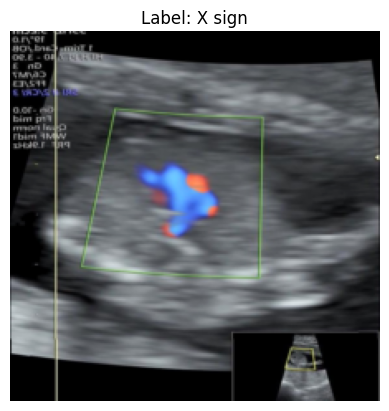

In [ ]:
# prompt: viết code xuất ảnh img

# Display an image from the dataset
# Undo normalization for displaying
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

img_display = inv_normalize(img)
plt.imshow(img_display.permute(1, 2, 0).numpy())
plt.title(f'Label: {classes[label]}')
plt.axis('off')
plt.show()


In [ ]:
#phase 2: 10 epoch
count = 0 #phiên bản
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataset_both_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset_both_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    valid_loss, correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_epoch_loss = valid_loss / len(valid_loader.dataset)
    accuracy = correct.double() / len(valid_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='macro')
    valid_losses.append(valid_epoch_loss)
    accuracies.append(accuracy.item())

    print(f"Phase 2: Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {valid_epoch_loss:.4f}, Acc = {accuracy:.4f}, F1 Score(macro) ={f1:.4f} ")

Phase 2: Epoch 1: Train Loss = 0.0543, Val Loss = 0.0787, Acc = 0.9691, F1 Score(macro) =0.7663 
Phase 2: Epoch 2: Train Loss = 0.0237, Val Loss = 0.0833, Acc = 0.9643, F1 Score(macro) =0.7703 
Phase 2: Epoch 3: Train Loss = 0.0196, Val Loss = 0.0729, Acc = 0.9643, F1 Score(macro) =0.7705 
Phase 2: Epoch 4: Train Loss = 0.0172, Val Loss = 0.0496, Acc = 0.9770, F1 Score(macro) =0.7832 
Phase 2: Epoch 5: Train Loss = 0.0131, Val Loss = 0.0755, Acc = 0.9627, F1 Score(macro) =0.7643 
Phase 2: Epoch 6: Train Loss = 0.0080, Val Loss = 0.0724, Acc = 0.9683, F1 Score(macro) =0.7810 
Phase 2: Epoch 7: Train Loss = 0.0029, Val Loss = 0.0438, Acc = 0.9778, F1 Score(macro) =0.7812 
Phase 2: Epoch 8: Train Loss = 0.0010, Val Loss = 0.0362, Acc = 0.9770, F1 Score(macro) =0.7770 
Phase 2: Epoch 9: Train Loss = 0.0048, Val Loss = 0.0805, Acc = 0.9707, F1 Score(macro) =0.7682 
Phase 2: Epoch 10: Train Loss = 0.0037, Val Loss = 0.0552, Acc = 0.9770, F1 Score(macro) =0.7758 


In [ ]:

valid_loss, correct = 0.0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

       Aorta       0.79      0.97      0.87        96
       Flows       1.00      0.98      0.99       175
       Other       0.97      0.97      0.97       628
      V sign       0.99      0.99      0.99       362
      X sign       0.91      0.75      0.82        91

    accuracy                           0.96      1352
   macro avg       0.93      0.93      0.93      1352
weighted avg       0.96      0.96      0.96      1352

Confusion Matrix:
[[ 93   0   0   0   3]
 [  0 172   3   0   0]
 [ 14   0 608   3   3]
 [  0   0   2 359   1]
 [ 10   0  12   1  68]]


In [ ]:
#phase 3: 10 epoch
count = 0 #phiên bản
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    valid_loss, correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_epoch_loss = valid_loss / len(valid_loader.dataset)
    accuracy = correct.double() / len(valid_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='macro')
    valid_losses.append(valid_epoch_loss)
    accuracies.append(accuracy.item())

    print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {valid_epoch_loss:.4f}, Acc = {accuracy:.4f}, F1 Score(macro) ={f1:.4f} ")

    if f1 > best_f1:
        best_f1 = f1
        pathbestmodel = f'/content/drive/MyDrive/Colab Notebooks/model/model_besttransformnew_editnew_phase3_{count}.pt'
        torch.save(model.state_dict(), pathbestmodel)
        count+=1
        print("✅ Saved best model!")

Epoch 1: Train Loss = 0.0343, Val Loss = 0.2229, Acc = 0.9327, F1 Score(macro) =0.9085 
Epoch 2: Train Loss = 0.0112, Val Loss = 0.3114, Acc = 0.9349, F1 Score(macro) =0.8932 
Epoch 3: Train Loss = 0.0162, Val Loss = 0.1843, Acc = 0.9541, F1 Score(macro) =0.9277 
Epoch 4: Train Loss = 0.0069, Val Loss = 0.2221, Acc = 0.9475, F1 Score(macro) =0.9088 
Epoch 5: Train Loss = 0.0075, Val Loss = 0.2333, Acc = 0.9416, F1 Score(macro) =0.9121 
Epoch 6: Train Loss = 0.0093, Val Loss = 0.2120, Acc = 0.9504, F1 Score(macro) =0.9180 
Epoch 7: Train Loss = 0.0169, Val Loss = 0.3460, Acc = 0.9223, F1 Score(macro) =0.8618 
Epoch 8: Train Loss = 0.0121, Val Loss = 0.2550, Acc = 0.9223, F1 Score(macro) =0.8698 
Epoch 9: Train Loss = 0.0173, Val Loss = 0.2740, Acc = 0.9379, F1 Score(macro) =0.8857 


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/dataset/Densenet201/model_besttransformnew_phase2_1.pt'))
model.eval()

DenseNet201_CBAM(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
#phase 4: 10 epoch
count = 0 #phiên bản
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    valid_loss, correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_epoch_loss = valid_loss / len(valid_loader.dataset)
    accuracy = correct.double() / len(valid_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='macro')
    valid_losses.append(valid_epoch_loss)
    accuracies.append(accuracy.item())

    print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {valid_epoch_loss:.4f}, Acc = {accuracy:.4f}, F1 Score(macro) ={f1:.4f} ")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/dataset/Densenet201/model_besttransformnew_phase4_{count}.pt')
        count+=1
        print("✅ Saved best model!")

Epoch 1: Train Loss = 0.0057, Val Loss = 0.2098, Acc = 0.9534, F1 Score(macro) =0.9168 
Epoch 2: Train Loss = 0.0158, Val Loss = 0.2090, Acc = 0.9053, F1 Score(macro) =0.8551 
Epoch 3: Train Loss = 0.0117, Val Loss = 0.1902, Acc = 0.9475, F1 Score(macro) =0.9047 
Epoch 4: Train Loss = 0.0194, Val Loss = 0.3265, Acc = 0.9186, F1 Score(macro) =0.8867 
Epoch 5: Train Loss = 0.0239, Val Loss = 0.2182, Acc = 0.9364, F1 Score(macro) =0.8722 
Epoch 6: Train Loss = 0.0050, Val Loss = 0.1847, Acc = 0.9519, F1 Score(macro) =0.9233 
Epoch 7: Train Loss = 0.0033, Val Loss = 0.1638, Acc = 0.9675, F1 Score(macro) =0.9401 
Epoch 8: Train Loss = 0.0034, Val Loss = 0.2117, Acc = 0.9504, F1 Score(macro) =0.8938 
Epoch 9: Train Loss = 0.0028, Val Loss = 0.2231, Acc = 0.9534, F1 Score(macro) =0.9082 


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/dataset/Densenet201/model_besttransformnew_phase2_1.pt'))
model.eval()
for epoch in range(1):
  model.eval()
  valid_loss, correct = 0.0, 0
  all_preds, all_labels = [], []
  with torch.no_grad():
      for inputs, labels in valid_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          valid_loss += loss.item() * inputs.size(0)
          _, preds = torch.max(outputs, 1)
          correct += torch.sum(preds == labels.data)
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

       Aorta       0.94      0.91      0.92        96
       Flows       0.99      0.97      0.98       175
       Other       0.97      0.98      0.98       628
      V sign       0.98      0.99      0.98       362
      X sign       0.90      0.82      0.86        91

    accuracy                           0.97      1352
   macro avg       0.95      0.93      0.94      1352
weighted avg       0.97      0.97      0.97      1352

Confusion Matrix:
[[ 87   0   3   1   5]
 [  0 170   3   2   0]
 [  2   0 618   5   3]
 [  0   2   3 357   0]
 [  4   0  11   1  75]]


In [ ]:
# Test prediction
model.eval()
test_predictions, all_labels = [], []
with torch.no_grad():
    for inputs,labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print("Classification Report:")
print(classification_report(all_labels, test_predictions, target_names=classes))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, test_predictions))

In [ ]:
# Evaluation
from torchvision.utils import make_grid
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import torchvision
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Predict test set
model.eval()
test_predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())

# ✅ Grad-CAM: Hiển thị vùng mô hình tập trung vào ảnh bị nhầm
print("Grad-CAM cho ảnh bị nhầm giữa 'Other' và 'X sign':")
cam_extractor = GradCAM(model, target_layer="features.denseblock4.denselayer32.conv2")
model.eval()

for idx, (img_tensor, label, pred) in enumerate(wrong_other_xsign[:3]):
    img_input = img_tensor.unsqueeze(0).to(device)
    img_input.requires_grad = True
    out = model(img_input)
    class_idx = pred if label != pred else label

    activation_map = cam_extractor(class_idx, out)
    result = overlay_mask(
        to_pil_image(img_input.squeeze().cpu()),
        to_pil_image(activation_map[0].squeeze(0), mode='F'),
        alpha=0.5
    )
    display(result)
    print(f"True: {classes[label]} | Pred: {classes[pred]}")

# ✅ Hiển thị ảnh bị nhầm sang Other
print("Ảnh bị nhầm sang lớp 'Other':")
wrong_to_other = []
for idx, (img_tensor, label) in enumerate(test_dataset):
    img_input = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = torch.argmax(model(img_input), dim=1).item()
    if label != 2 and pred == 2:
        wrong_to_other.append((img_tensor, label))

if wrong_to_other:
    fig, axs = plt.subplots(1, min(5, len(wrong_to_other)), figsize=(15, 3))
    for i, (img_tensor, label) in enumerate(wrong_to_other[:5]):
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f"True: {classes[label]}")
        axs[i].axis('off')
    plt.suptitle("Ảnh nhầm sang 'Other'", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Không có ảnh nào bị nhầm sang 'Other'.")

# ✅ Hiển thị ảnh bị nhầm giữa 'Other' và 'X sign'
print("Ảnh nhầm giữa 'Other' và 'X sign':")
wrong_other_xsign = []
for idx, (img_tensor, label) in enumerate(test_dataset):
    img_input = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = torch.argmax(model(img_input), dim=1).item()
    if (label == 2 and pred == 4) or (label == 4 and pred == 2):
        wrong_other_xsign.append((img_tensor, label, pred))

if wrong_other_xsign:
    fig, axs = plt.subplots(1, min(5, len(wrong_other_xsign)), figsize=(15, 3))
    for i, (img_tensor, label, pred) in enumerate(wrong_other_xsign[:5]):
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f"True: {classes[label]}Pred: {classes[pred]}")
        axs[i].axis('off')
    plt.suptitle("Ảnh nhầm giữa 'Other' và 'X sign'", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Không có ảnh nhầm giữa 'Other' và 'X sign'.")

# ✅ Hiển thị ảnh X sign bị nhầm
print("\nẢnh X sign bị nhầm dự đoán:")
wrong_xsign = []
for idx, (img_tensor, label) in enumerate(test_dataset):
    img_input = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_input)
        pred = torch.argmax(output, dim=1).item()
    if label == 4 and pred != 4:  # X sign thật nhưng bị nhầm
        wrong_xsign.append((img_tensor, pred))

# Hiển thị tối đa 5 ảnh nhầm X sign
if wrong_xsign:
    fig, axs = plt.subplots(1, min(5, len(wrong_xsign)), figsize=(15, 3))
    for i, (img_tensor, pred) in enumerate(wrong_xsign[:5]):
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f"Predicted: {classes[pred]}")
        axs[i].axis('off')
    plt.suptitle("X sign bị nhầm lẫn", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Không có ảnh X sign nào bị nhầm.")


In [ ]:
import pandas as pd
from collections import Counter

In [ ]:
# Plotting
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
test_counts = Counter(test_predictions)
labels = [classes[i] for i in test_counts.keys()]
counts = list(test_counts.values())

plt.figure()
plt.bar(labels, counts)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Distribution of Test Predictions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.tight_layout()
plt.show()

In [ ]:
print(f'Total test images: {len(train_dataset)}')
print(f'Total test images: {len(valid_dataset)}')
print(f'Total test images: {len(test_dataset)}')

In [ ]:


train_values = 0
valid_values = 0
test_values = 0

for thumuc in os.listdir(main_folder):
    path = os.path.join(main_folder, thumuc)
    total = 0
    print(f'{thumuc}: {len(os.listdir(path))}')
    for thu in os.listdir(path):
        path_thu = os.path.join(path, thu)
        so_file = len(os.listdir(path_thu))
        print(f'\t{thu}: {so_file}')
        total += so_file

    if 'train' in thumuc.lower():
        train_values += total
    elif 'valid' in thumuc.lower():
        valid_values += total
    elif 'test' in thumuc.lower():
        test_values += total

print(f'\nTổng số ảnh:')
print(f'Train: {train_values}')
print(f'Valid: {valid_values}')
print(f'Test: {test_values}')


In [ ]:
test_folder = os.path.join(main_folder, 'test')
print("Test folder path:", test_folder)
print("Files in test folder:", os.listdir(test_folder))

In [ ]:
# Hiển thị 5 ảnh đầu tiên trong train_dataset
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img_tensor, label = train_dataset[i]  # Lấy ảnh và nhãn
    img = img_tensor.permute(1, 2, 0).numpy()  # Chuyển từ [C, H, W] -> [H, W, C]

    # Unnormalize để ảnh hiển thị đúng màu
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    axs[i].imshow(img)
    #axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.suptitle("Một số ảnh từ tập huấn luyện", fontsize=16)
plt.tight_layout()
plt.show()